In [1]:
!apt-get install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 2s (100 kB/s) 
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 6773 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1.1) ...
Setting up unzip (6.0-21ubuntu1.1) ...


In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [41]:
!pip install transformers sklearn pandas matplotlib

     |████████████████████████████████| 10.3 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 14.8 MB/s eta 0:00:01


In [48]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# pytortch и huggingface 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from transformers import AutoModel
from transformers import AutoTokenizer


Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [6]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [7]:
data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
                      data[data.topic=='Мир'].sample(frac=0.001),
                      data[data.topic=='Экономика'].sample(frac=0.002),
                      data[data.topic=='Спорт'].sample(frac=0.003),
                      data[data.topic=='Наука и техника'].sample(frac=0.005),
                      data[data.topic=='Бывший СССР'].sample(frac=0.005),
                      data[data.topic=='Культура'].sample(frac=0.005),
                      data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
                      data[data.topic=='Из жизни'].sample(frac=0.01),
                      data[data.topic=='Дом'].sample(frac=0.01),
                      data[data.topic=='Силовые структуры'].sample(frac=0.01),
                      data[data.topic=='Ценности'].sample(frac=0.03),
                      data[data.topic=='Бизнес'].sample(frac=0.03),
                      data[data.topic=='69-я параллель'].sample(frac=0.05),
                      data[data.topic=='Крым'].sample(frac=0.05),
                      data[data.topic=='Культпросвет'].sample(frac=0.2),
                      data[data.topic=='Легпром'].sample(frac=0.8),
                      data[data.topic=='Библиотека']]).reset_index(drop=True)

In [8]:
data_frac.topic.value_counts()

Из жизни             55
Бывший СССР          54
Наука и техника      54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

In [9]:
data_frac.shape

(607, 6)

In [10]:
data = data_frac

### Загружаем предобученную модель из huggingface transformers

Список всех доступных моделей можно найти тут - https://huggingface.co/models  
А вот тут основные с описанием - https://huggingface.co/transformers/pretrained_models.html

На HG предпочитают торч, поэтому, если вы решили работать в торче, вам повезло. 

Данные у нас на русском, поэтому мы возьмем rubert от DeepPavlov (остальные модели загружаются также)

In [11]:
# # Eng Bert
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# model_bert = AutoModel.from_pretrained('bert-base-cased')

In [12]:
# # Rubert - от IPavlov
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased").to(torch.device('cuda'))

In [5]:
# # Multilingual Bert - от гугла
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model_bert = AutoModel.from_pretrained('bert-base-multilingual-cased')

Мы загружаем не только модель, а еще и токенайзер, т.е. свою предобработку нам писать не нужно

In [13]:
data.loc[0, 'title']

'Барнаульцы устроили давку на\xa0открытии первого в\xa0городе «Макдоналдса»'

Перевести токены в индексы очень просто

In [15]:
tokenizer.encode(data.loc[0, 'title'])

[101,
 10876,
 63355,
 2230,
 4402,
 31022,
 9167,
 3247,
 1469,
 28136,
 9825,
 845,
 6925,
 304,
 16401,
 38344,
 27384,
 3730,
 326,
 102]

В этих моделях как правило используется BPE

In [16]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[0, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'бар',
 '##нау',
 '##ль',
 '##цы',
 'устроили',
 'дав',
 '##ку',
 'на',
 'открытии',
 'первого',
 'в',
 'городе',
 '«',
 'мак',
 '##дона',
 '##лд',
 '##са',
 '»',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [17]:
text = data.loc[0, 'title']
text_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
output = model_bert(text_ids.to(torch.device('cuda')))

На выходе мы получим tuple из двух элементов. 

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [18]:
output[0].size() # в пайторче вместо .shape используется size()

torch.Size([1, 20, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [19]:
output[1].size()

torch.Size([1, 768])

Обычно в задачах используют либо состояние первого элемента

In [20]:
output[0][:,0].size()

torch.Size([1, 768])

Либо усредненное состояние 

In [21]:
torch.mean(output[0], axis=1).size()

torch.Size([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Датасет и трейн/тест лупы возьмем из предыдущих семинаров. Единственное изменение - в датасете мы используем токенайзер

In [26]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [27]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            
    return np.mean(epoch_f1)# / len(iterator)

In [28]:
# в берте максимальная длина обычно ограничена 512
MAX_LEN = 512

In [29]:
texts = data.title.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [30]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

Берт - очень большая модель, поэтому с батчсайзом нужно быть аккуратнее

In [32]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [36]:
import torch.nn as nn

class CLF(nn.Module):
    
    def __init__(self, pretrained_model, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes) 
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        # берем самое первое состояние и применяем к нему линейный слой и активацию
        dense_outputs=self.fc(self.drop(hidden[:,0] ))
        outputs=self.act(dense_outputs)
        
        return outputs

Лосс при дообучении нужно брать поменьше (2e-5, 2e-6, 2e-7)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

Модель готова

In [38]:
f1s = []
f1s_eval = []

for i in range(20):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.35833333333333334
1
Eval -  0.5833333333333333
2
Eval -  0.5520833333333333
3
Eval -  0.5166666666666666
4
Eval -  0.5833333333333333
5
Eval -  0.5479166666666666
6
Eval -  0.5479166666666666
7
Eval -  0.5520833333333333
8
Eval -  0.5541666666666667
9
Eval -  0.58125
10
Eval -  0.5458333333333334
11
Eval -  0.5750000000000001
12
Eval -  0.5458333333333334
13
Eval -  0.5479166666666666
14
Eval -  0.5479166666666666
15
Eval -  0.55
16
Eval -  0.5541666666666667
17
Eval -  0.5458333333333334
18
Eval -  0.5458333333333334
19
Eval -  0.5479166666666666


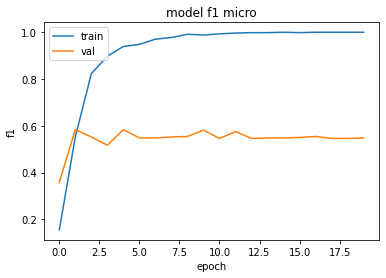

In [43]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
max(f1s_eval)

0.5833333333333333

Такое значение Ф-меры конечно не впечатляет, но нужно помнить, что мы обучались на 600 примерах. Никакая нейронка не обучится на таком количестве данных. 

Вот для сравнения LSTM

In [50]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))


# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens


MAX_LEN = 50

texts = data.title.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05,
                                                                         stratify=data.topic)

training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True, )

valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [51]:
class Clf(nn.Module):
    
    def __init__(self, output_dim):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = 30
        self.RNN_UNITS = 128
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, num_layers=1, 
                           batch_first=True)
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        rnn_output, (h, *_) = self.rnn(embedded)
        output = self.act(self.fc(h[-1]))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [53]:
f1s = []
f1s_eval = []

for i in range(50):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 100))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.12903225806451613
1
Eval -  0.16129032258064516
2
Eval -  0.1935483870967742
3
Eval -  0.16129032258064516
4
Eval -  0.12903225806451613
5
Eval -  0.0967741935483871
6
Eval -  0.12903225806451613
7
Eval -  0.12903225806451613
8
Eval -  0.12903225806451613
9
Eval -  0.12903225806451613
10
Eval -  0.0967741935483871
11
Eval -  0.16129032258064516
12
Eval -  0.12903225806451613
13
Eval -  0.0967741935483871
14
Eval -  0.16129032258064516
15
Eval -  0.12903225806451613
16
Eval -  0.06451612903225806
17
Eval -  0.0967741935483871
18
Eval -  0.0967741935483871
19
Eval -  0.12903225806451613
20
Eval -  0.16129032258064516
21
Eval -  0.0967741935483871
22
Eval -  0.12903225806451613
23
Eval -  0.12903225806451613
24
Eval -  0.0967741935483871
25
Eval -  0.0967741935483871
26
Eval -  0.12903225806451613
27
Eval -  0.0967741935483871
28
Eval -  0.12903225806451613
29
Eval -  0.0967741935483871
30
Eval -  0.12903225806451613
31
Eval -  0.0967741935483871
32
Eval -  0.12903225806451613

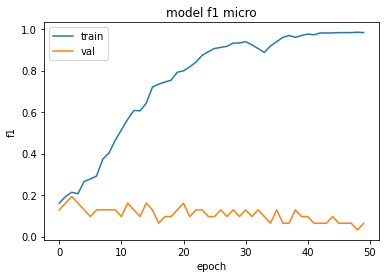

In [54]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()